In [2]:
# Importing the Libraries
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import collections
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

### The below cell reads the data obtained from Bigquery. This data was prepared by our team using time series analysis for bots and non-bots wallets

For our use case, we hypothesised that any wallet which performs multiple transactions at pre-defined time intervals(with minor deviations) can be safely assumed to be a bot, as proposed by this paper : https://arxiv.org/pdf/1810.01591.pdf. We therefore, write a python script to extract all such wallets, and prepare our dataset

In [13]:
# Label Generation
raw_df = pd.read_csv('./Opensea_Users.csv')
raw_df = raw_df[raw_df['trans_count'] >= 10]
all_bot_wallets = []
for i in range(1, 40000) :
    temp_val= float(i/10)
    temp_df = raw_df[raw_df['avg_min_send_trans'] == temp_val]
    temp_add = list(temp_df['address'])
    for add in temp_add :
        all_bot_wallets.append(add)


<AxesSubplot:ylabel='Frequency'>

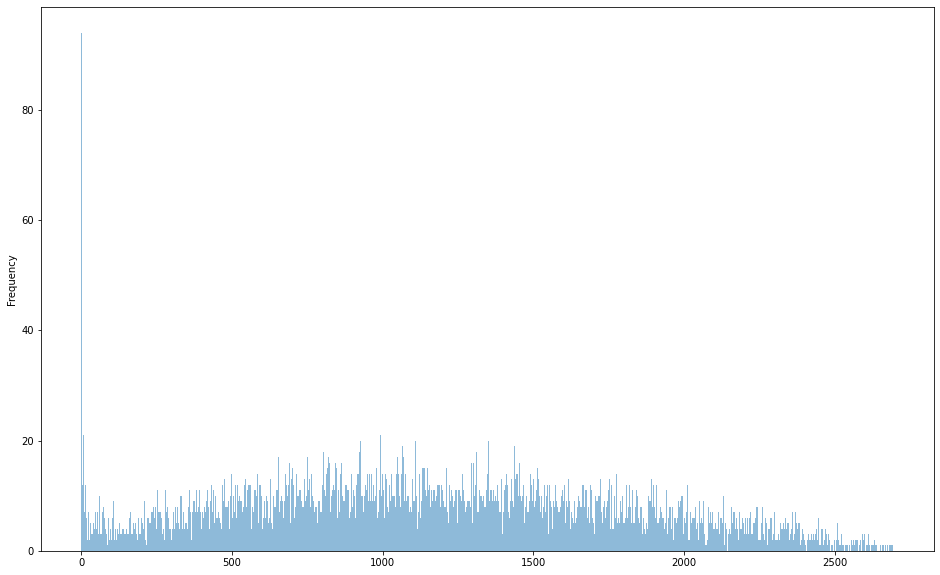

In [31]:
# We plot the average sent distribution over time for the data
raw_df['avg_min_send_trans'].plot.hist(bins=1500, alpha=0.5,figsize=(16, 10))

### We have now labelled the bot wallets using Time series analysis. We determine those wallets which transact with a pre-defined time period, and have a minimum of 10 transactions. We now move forward to further analysis

In [15]:
# Reading the dataset
final_data = pd.read_csv('./input.csv')
final_data

,address,average_sent,sent_count,avg_time_sent,max_sent,average_rec,rec_count,avg_time_rec,max_rec,total_trans,labels
0,0xf19f62f44e61bf9913afeade70eeb14b78bc6df8,0.615724,34,829.529412,2.025000,4.221049,3,5886.666667,7.664683,37,1
1,0xf3b1ae06392b7c0be9745727489da8349b504b99,0.025156,28,657.678571,0.344000,0.013540,3,5654.333333,0.015459,31,1
2,0xf44e3486fbf5dd567e940460d6b59915f97d6904,0.019811,211,198.132701,0.505000,0.104644,21,1744.476190,0.605601,232,1
3,0x6f4ca5ad61fbf939e810070c92a988937470e31b,0.076437,160,262.175000,2.200000,0.177548,8,5243.000000,0.674850,168,1
4,0x25bfb4440eabe6316568c1037ca15de16a3b55d0,0.074301,116,340.775862,1.500000,1.633640,1,0.000000,1.633640,117,1
...,...,...,...,...,...,...,...,...,...,...,...
2660,0xd318e31ecb632562e1e08ab3593a74da041249d3,1.469714,7,4613.571429,10.000000,0.270000,2,3696.000000,0.500000,9,0
2661,0xda091372014c4d7ee4ec32d83383f7ba7dff36a1,3.398110,168,114.375000,123.000000,103.040735,2,367.500000,206.081470,170,0
2662,0x7c90c6cacb389f149297fffee6255cba093bc4c2,0.232154,7,5428.142857,0.781862,0.055702,2,17925.500000,0.073686,9,0
2663,0xdbec5f351c3e2b9d49f75d530393d2899897b75a,0.005261,21,1251.238095,0.090000,0.100000,1,0.000000,0.100000,22,0


#### The meaning of the different features is explained below:

- address : The address of the wallet
- average_sent : The average value of the sent transactions(in ether)
- sent_count : The total number of sent transactions
- avg_time_sent : The average time difference between two consecutive sent transactions
- max_sent : The maximum value of the sent transactions(in ether)
- average_rec : The average value of the ether received(in ether)
- rec_count : The total number of received transactions
- avg_time_rec : The average time difference between two consecutive received transactions
- max_rec : The maximum value of the received transactions(in ether)
- total_trans : The total number of the transactions
- labels : The label assigned by our algorithm

Google Bigquery has been used for the generation of the above features. These features have been extracted for the month of November for OpenSea Users.

In [17]:
# Normalizing the features using PowerTransformer
tmm = final_data.drop(['address','labels'], axis = 1)
norm = PowerTransformer()
norm_train_f = norm.fit_transform(tmm)
norm_df = pd.DataFrame(norm_train_f, columns=tmm.columns)
norm_df

,average_sent,sent_count,avg_time_sent,max_sent,average_rec,rec_count,avg_time_rec,max_rec,total_trans
0,1.306726,-0.129855,0.253631,0.490696,1.714520,-0.140231,0.972123,1.580757,-0.172536
1,-0.757030,-0.358805,-0.006998,-0.671680,-1.018909,-0.140231,0.944469,-1.152561,-0.391313
2,-0.798797,1.902411,-1.102893,-0.465813,-0.671302,1.678108,0.245841,-0.038220,1.903396
3,-0.394607,1.609952,-0.880716,0.548701,-0.439250,0.893746,0.893328,0.041938,1.564933
4,-0.408427,1.262790,-0.655311,0.275535,1.227609,-1.368604,-1.518346,0.725013,1.172082
...,...,...,...,...,...,...,...,...,...
2660,1.879889,-2.019478,2.846197,1.373126,-0.190574,-0.605086,0.668477,-0.174393,-1.984507
2661,2.087272,1.661944,-1.488472,1.844286,2.008298,-0.605086,-0.418503,1.962926,1.577542
2662,0.389218,-2.019478,3.166594,-0.188314,-0.849033,-0.605086,1.855037,-0.989389,-1.984507
2663,-0.916723,-0.701233,0.761145,-1.100393,-0.687349,-1.368604,-1.518346,-0.921202,-0.823376


In [18]:
norm_df['labels'] = final_data['labels']

In [19]:
# Generating K-means clustering 
num_clusters = range(1, 20)
norm_df_temp = norm_df.drop(['labels'], axis = 1)
norm_df_temp


,average_sent,sent_count,avg_time_sent,max_sent,average_rec,rec_count,avg_time_rec,max_rec,total_trans
0,1.306726,-0.129855,0.253631,0.490696,1.714520,-0.140231,0.972123,1.580757,-0.172536
1,-0.757030,-0.358805,-0.006998,-0.671680,-1.018909,-0.140231,0.944469,-1.152561,-0.391313
2,-0.798797,1.902411,-1.102893,-0.465813,-0.671302,1.678108,0.245841,-0.038220,1.903396
3,-0.394607,1.609952,-0.880716,0.548701,-0.439250,0.893746,0.893328,0.041938,1.564933
4,-0.408427,1.262790,-0.655311,0.275535,1.227609,-1.368604,-1.518346,0.725013,1.172082
...,...,...,...,...,...,...,...,...,...
2660,1.879889,-2.019478,2.846197,1.373126,-0.190574,-0.605086,0.668477,-0.174393,-1.984507
2661,2.087272,1.661944,-1.488472,1.844286,2.008298,-0.605086,-0.418503,1.962926,1.577542
2662,0.389218,-2.019478,3.166594,-0.188314,-0.849033,-0.605086,1.855037,-0.989389,-1.984507
2663,-0.916723,-0.701233,0.761145,-1.100393,-0.687349,-1.368604,-1.518346,-0.921202,-0.823376


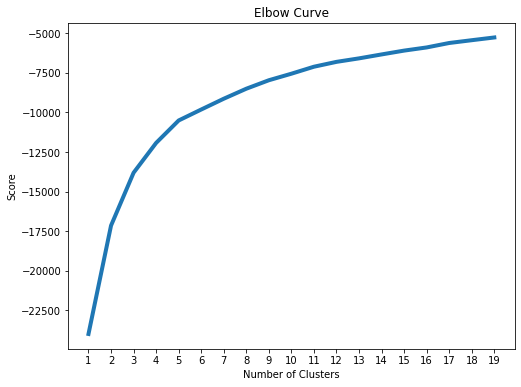

In [20]:
kmeans = [KMeans(n_clusters=i, random_state=42).fit(norm_df_temp) for i in num_clusters]
scores = [kmeans[i].score(norm_df_temp) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(num_clusters, scores, linewidth = 4)
plt.xticks(num_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

In [21]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(norm_df_temp)

KMeans(n_clusters=2)

In [22]:
# Calculating Correlation between the our assigned labels and the labels given by K-means clustering
labels = kmeans.labels_
y = list(norm_df['labels'])
corr, _ = pearsonr(y, labels)
print('Pearsons correlation: %.3f' % abs(corr))

Pearsons correlation: 0.502


In [35]:
# Generating t-SNE for the data
temp_data = pd.read_csv('./bt.csv')
temp_data_new = temp_data.drop(['address','labels'], axis = 1)

/home/parth/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/parth/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 42667 samples in 0.054s...
[t-SNE] Computed neighbors for 42667 samples in 1.931s...
[t-SNE] Computed conditional probabilities for sample 1000 / 42667
[t-SNE] Computed conditional probabilities for sample 2000 / 42667
[t-SNE] Computed conditional probabilities for sample 3000 / 42667
[t-SNE] Computed conditional probabilities for sample 4000 / 42667
[t-SNE] Computed conditional probabilities for sample 5000 / 42667
[t-SNE] Computed conditional probabilities for sample 6000 / 42667
[t-SNE] Computed conditional probabilities for sample 7000 / 42667
[t-SNE] Computed conditional probabilities for sample 8000 / 42667
[t-SNE] Computed conditional probabilities for sample 9000 / 42667
[t-SNE] Computed conditional probabilities for sample 10000 / 42667
[t-SNE] Computed conditional probabilities for sample 11000 / 42667
[t-SNE] Computed conditional probabilities for sample 12000 / 42667
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

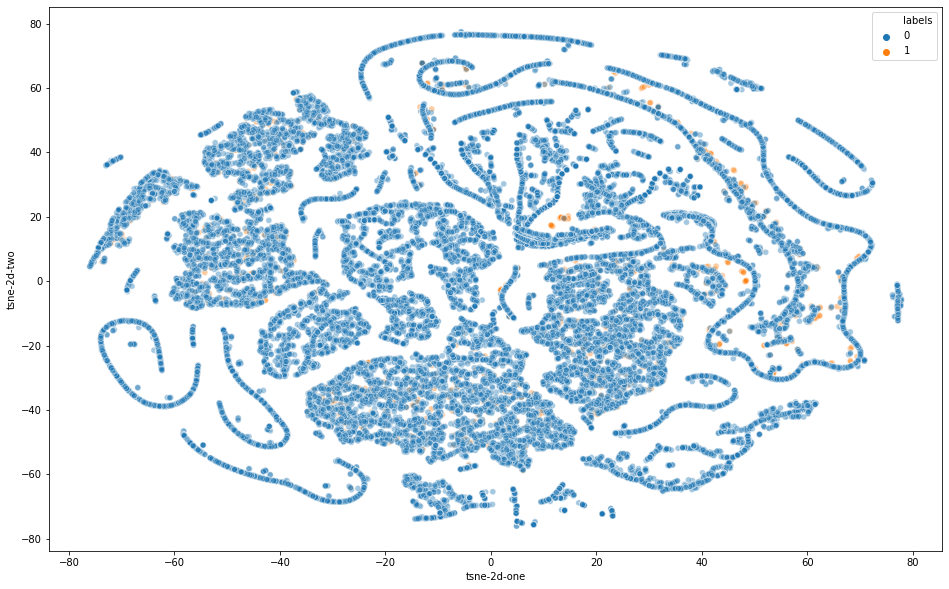

In [38]:
tsne = TSNE(n_components=2, verbose=1, perplexity=45)
tsne_results = tsne.fit_transform(temp_data_new)
temp_data['tsne-2d-one'] = tsne_results[:,0]
temp_data['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="labels",
    data= temp_data,
    legend="full",
    alpha=0.4
)

### We now downsample the dataset to have a clear visualization of the separation layer

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 2665 samples in 0.003s...
[t-SNE] Computed neighbors for 2665 samples in 0.152s...


/home/parth/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/parth/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2665
[t-SNE] Computed conditional probabilities for sample 2000 / 2665
[t-SNE] Computed conditional probabilities for sample 2665 / 2665
[t-SNE] Mean sigma: 0.588934
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.289185
[t-SNE] KL divergence after 1000 iterations: 1.070882


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

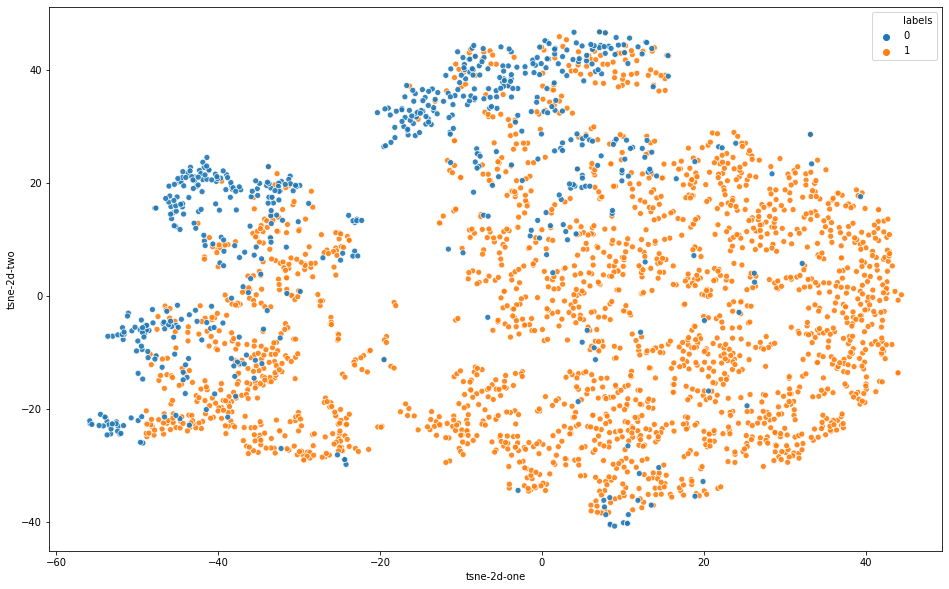

In [23]:
#Generating a TSNE to validate the data
tsne = TSNE(n_components=2, verbose=1, perplexity=45)
tsne_results = tsne.fit_transform(norm_df_temp)
norm_df['tsne-2d-one'] = tsne_results[:,0]
norm_df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="labels",
    data= norm_df,
    legend="full",
    alpha=0.9
)

In [24]:
#Training a model 
# Split the data into x_train and y_train data sets
y = norm_df['labels']
X = norm_df.drop(['labels', 'tsne-2d-one','tsne-2d-two'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [25]:
# Training the model
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# Generating classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.66      0.74       131
           1       0.90      0.96      0.93       402

    accuracy                           0.89       533
   macro avg       0.87      0.81      0.83       533
weighted avg       0.88      0.89      0.88       533



In [26]:
#Saving the model
import joblib
joblib.dump(clf, "./random_forest.joblib")

['./random_forest.joblib']

### Hypothesis Testing

In order to verify our hypothesis, we now extract wallets which interacted with OpenSea for the month of October, and generate labels using time series analysis. We then generate labels using our ML model, and check the accuracy of the model

In [27]:
#Utility code to process the test data: dropping the address column and normalizing features
def process_data(data_path) :
    temp = pd.read_csv(data_path)
    temp = temp.drop(['address'], axis = 1)
    norm_temp_f = norm.fit_transform(temp)
    norm_temp = pd.DataFrame(norm_temp_f, columns=temp.columns)
    return norm_temp

In [28]:
# Reading the bots data
bots_oct = process_data('./bots_oct.csv')
bots_oct

,average_sent,sent_count,avg_time_sent,max_sent,average_rec,rec_count,avg_time_rec,max_rec,total_trans
0,2.156905,-0.455394,0.906892,1.732871,1.906893,0.002516,0.293055,1.497768,-0.455984
1,-0.415073,1.261948,-0.773609,-0.213601,-0.622632,0.228390,0.996686,-0.803971,1.206587
2,-0.926966,0.623360,-0.267664,-1.035629,-0.925556,1.422686,0.223185,-0.769090,0.724544
3,-0.170484,-0.109871,-0.500760,-0.013435,-1.196589,0.002516,-1.591131,-1.244115,-0.135718
4,2.081481,0.558199,-0.232924,1.854623,2.043132,0.002516,0.756263,1.904200,0.509200
...,...,...,...,...,...,...,...,...,...
1508,-0.926354,-2.173807,-2.682670,-1.281058,-0.935050,-1.401204,-1.591131,-1.100744,-2.174703
1509,-1.207303,-1.423725,0.459353,-1.330299,1.105740,-1.401204,-1.591131,0.325400,-1.520837
1510,2.182058,-1.707585,0.888588,1.027924,1.673119,-0.295969,0.113648,1.210940,-1.520837
1511,-1.158977,-1.552405,-0.549690,-1.309807,-1.150918,-1.401204,-1.591131,-1.219471,-1.641721


In [29]:
test_vals = clf.predict(bots_oct)
counter = collections.Counter(test_vals)
print(f'Accuracy of Bot Detection : {counter[1]/(counter[0] + counter[1])}')

Accuracy of Bot Detection : 0.7752808988764045


In [30]:
# Checking accuracy for non-bots
non_bots_oct = process_data('./non_bots_oct.csv')
test_vals = clf.predict(non_bots_oct)
counter = collections.Counter(test_vals)
print(f'Accuracy of Non-Bot Detection : {counter[1]/(counter[0] + counter[1])}')

Accuracy of Non-Bot Detection : 0.8142394822006472
